In [1]:
using Pkg
Pkg.activate("/Users/benniasoff/Vscode/chemlab/sound/env3")


  Activating project at `~/Vscode/chemlab/sound/env3`


In [2]:
using VideoIO

# Open the video file
reader = VideoIO.openvideo("second.mp4")


# Initialize an array to store frames with timestamps
frames = []
times =[]
_ , dur=VideoIO.get_time_duration("second.mp4")
num_frames=VideoIO.get_number_frames("second.mp4")
time_per_frame=dur/num_frames
# Read frames until the end of the video
num=0
while !eof(reader)
    try
        num += 1
        frame = read(reader)
        if num % 10 == 0  # Process every 25th frame
            push!(frames,frame) 
            push!(times,time_per_frame*num)
        end
    catch e
        if isa(e, EOFError)
            break  # End of video reached
        else
            rethrow(e)  # Rethrow if it's a different error
        end
    end
end

# Close the video reader

close(reader)

In [3]:
using ImageFiltering
include("Fucntions2.jl")
# second 2, 0.7

# Initialize the shared resources
signals = []
times1 = []

myLock = ReentrantLock()

Threads.@threads for i in 1:4:length(frames)
    pic = processImage(imfilter(frames[i], Kernel.Laplacian()), 2, 30, 2, 0.7)
    pic2 = transformImage(pic, 500)
    pic3 = pic2[60:440, 15:485]
    sig = get_signal(pic3)
    # Use the renamed lock to safely push to the arrays in a thread-safe manner
    lock(myLock) do
        push!(signals, sig)
        push!(times1, times[i])
    end
end


In [4]:
 LinearAlgebra

difference_vector = signals[4] - signals[end-1]
norm_of_difference = norm(difference_vector)
delete_index = []

for i in 1:length(signals)-1 

    thresh=0.09*(maximum(signals[i])-minimum(signals[i]))
    diff(signals[i])
    if norm(abs.(signals[i] - signals[end-1])) > norm_of_difference || 
    any(x -> x > thresh, diff(signals[i]))
        push!(delete_index, i)
    end
end

signals2=deepcopy(signals)
times2=deepcopy(times1)
println(delete_index)
deleteat!(signals2, delete_index)
deleteat!(times2, delete_index)



Any[1, 2, 3, 5, 10, 11, 12, 22, 25, 26, 29, 31, 36, 50, 58, 60, 61, 62, 65, 70, 73, 90]


70-element Vector{Any}:
   4.332755397649631
   6.999066411587866
   8.332221918556982
   9.665377425526101
  10.998532932495218
  16.331154960371688
  17.664310467340805
  18.99746597430992
  20.33062148127904
  21.663776988248156
  22.996932495217273
  24.33008800218639
  25.663243509155507
   ⋮
 105.65257392730254
 106.98572943427166
 108.31888494124078
 109.6520404482099
 110.98519595517901
 112.31835146214813
 113.65150696911725
 114.98466247608637
 116.31781798305548
 117.6509734900246
 120.31728450396284
 121.65044001093194

In [5]:
deleteat!(signals2, 70)
deleteat!(times2, 70)

69-element Vector{Any}:
   4.332755397649631
   6.999066411587866
   8.332221918556982
   9.665377425526101
  10.998532932495218
  16.331154960371688
  17.664310467340805
  18.99746597430992
  20.33062148127904
  21.663776988248156
  22.996932495217273
  24.33008800218639
  25.663243509155507
   ⋮
 104.31941842033342
 105.65257392730254
 106.98572943427166
 108.31888494124078
 109.6520404482099
 110.98519595517901
 112.31835146214813
 113.65150696911725
 114.98466247608637
 116.31781798305548
 117.6509734900246
 120.31728450396284

In [6]:

using FFTW
using Plots
plotlyjs()
p1 = plot(title="Original Signals", xlabel="Time", ylabel="Amplitude",
    title_location=:left)
p2 = plot(title="FFT of Signals", xlabel="Frequency (Hz)", ylabel="Magnitude",title_location=:left)

n = length(signals2[1]) 
fs = 2000 # Example sampling rate, adjust according to your signal
f = (0:n-1)*(fs/n)  # Frequency axis

norms = []
for (index, i) in enumerate(signals2[1:end])
    push!(norms, norm(i))
    fft_signal = fft(i)
    # fft_signal = fft_signal / maximum(abs.(fft_signal))


    # Add the original signal to the first plot
    plot!(p1, i, label="Signal $(index)")

    # Add the FFT to the second plot
    plot!(p2, f[2:Int(floor(n/8))], abs.(fft_signal[2:Int(floor(n/8))]), label="Signal $(index)")
end

# Optionally, adjust margins (example: bottom margin of p1 and top margin of p2)
p=plot(p1, p2, layout=(2,1), size=(900, 700),legend=false,)
savefig(p, "data.png")


WebIO._IJuliaInit()

┌ Warning: attempting to remove probably stale pidfile
│   path = "/Users/benniasoff/.jlassetregistry.lock"
└ @ Pidfile ~/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


"/Users/benniasoff/Vscode/chemlab/sound/data.png"

Fitting parameters: a = 73.49624565666747, b = -0.017094407486947554,c = -8.139214517464481


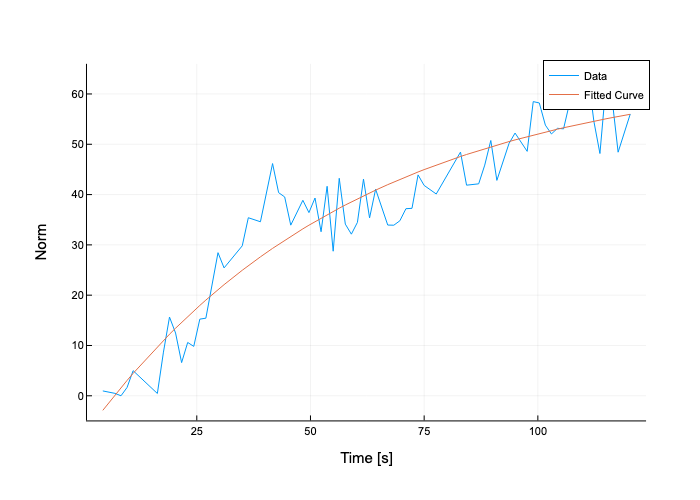

In [7]:
# Step 1: Load the LsqFit package
using LsqFit

# Step 2: Your data (assuming `times2` and `norms` are already defined)

norms = norms.-minimum(norms)
# Step 3: Define the model function
model(t, p) = p[1] * (1 .- exp.(p[2] .* t)) .+p[3]

# Step 4: Perform the fit
# Initial guesses for parameters a and b
p0 = [1, -0.1,40]
fit = curve_fit(model, times2, norms, p0)

# Step 5: Extract the fitting parameters
params = coef(fit)

# Display the fitting parameters
println("Fitting parameters: a = $(params[1]), b = $(params[2]),c = $(params[3])")

# Optionally, you can also use the fitted parameters to plot the fitted curve
using Plots
fitted_curve = model(times2, params)
plot(times2, norms, label="Data", xlabel="Time [s]", ylabel="Norm")
plot!(times2, fitted_curve, label="Fitted Curve")


In [8]:

# Filter indices for the desired frequency range
indices_in_range = findall(x -> x >= 0 && x <= 2000, f)

# Initialize a matrix to store the magnitudes of FFT components for each signal within the frequency range
fft_magnitudes = zeros(length(signals2), length(indices_in_range))

for (i, signal) in enumerate(signals2)
    fft_result = fft(signal)
    # fft_result = fft_result / sum(abs.(fft_result))
    # Store magnitudes of FFT components within the frequency range
    fft_magnitudes[i, :] = abs.(fft_result[indices_in_range])/sum(abs.(fft_result[indices_in_range]))
end

# Rank signals at each frequency point
# Initialize an array to store the rankings
rankings = zeros(Float64, size(fft_magnitudes))

for i in 1:size(fft_magnitudes, 2)
    # Sort indices based on magnitude for each frequency point
    # The sorting returns indices of signals in descending order of their magnitude
    sorted_indices = sortperm(fft_magnitudes[:, i], rev=false)
    rankings[:, i] = times2[sorted_indices]
end


In [9]:
for i in 1:length(signals2)
    println(sum(fft_magnitudes[i,:]))
end


1.0000000000000004
0.9999999999999998
1.000000000000001
0.9999999999999997
0.9999999999999996
1.0000000000000007
1.0000000000000002
0.9999999999999997
1.0000000000000002
1.0
0.9999999999999992
1.0000000000000002
0.9999999999999997
0.9999999999999999
1.0000000000000002
0.9999999999999993
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
0.9999999999999992
0.9999999999999998
0.9999999999999998
0.9999999999999994
1.0000000000000004
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000007
1.0000000000000002
1.0000000000000002
0.9999999999999994
1.0
0.9999999999999999
0.9999999999999999
1.0000000000000002
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999996
0.9999999999999998
1.0
1.0
0.9999999999999998
1.0000000000000002
1.0
1.0000000000000002
1.0000000000000002
0.9999999999999997
1.0
1.0000000000000004
0.9999999999999998
1.0000000000000002
0.9999999999999994
1.0000000000000002
0.9999999999999993
1.0000000000000

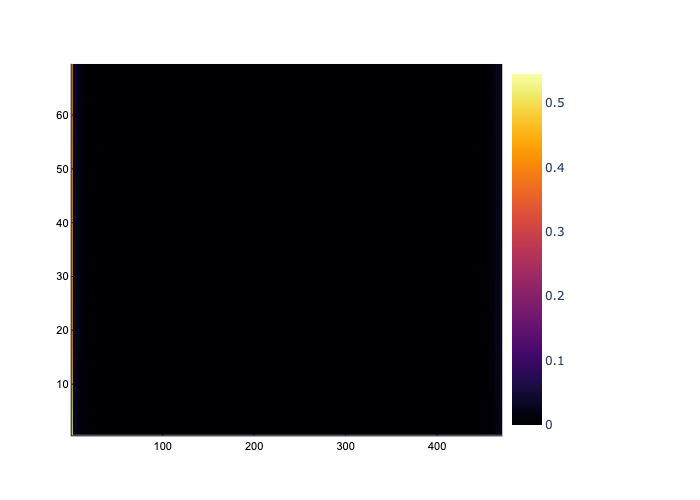

In [10]:
heatmap(fft_magnitudes)

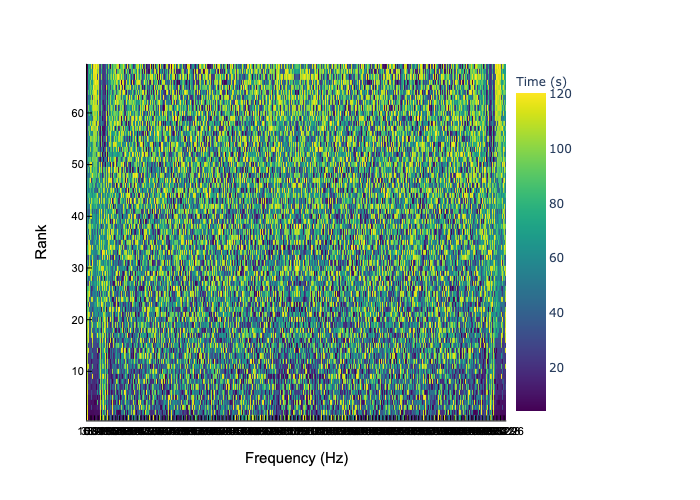

In [11]:
using Plots

# Assuming `frequencies` is the array of all frequencies and `indices_in_range` identifies the desired range
selected_frequencies = f[indices_in_range]

# Adjusting xticks to show only every fourth frequency
xtick_indices = 1:4:length(selected_frequencies)  # Select every fourth index
xtick_labels = round.(selected_frequencies[xtick_indices], digits=2)  # Corresponding frequency labels

p=heatmap(rankings, color=:viridis, cbar=true,
        xticks=(xtick_indices, xtick_labels),
        xlabel="Frequency (Hz)",
        ylabel="Rank",
        colorbar_title="Time (s)",
        size=(600, 400))
display(p)
       

[ Info: Saved animation to /Users/benniasoff/Vscode/chemlab/sound/fourier_transforms.gif


Plots.AnimatedGif("/Users/benniasoff/Vscode/chemlab/sound/fourier_transforms.gif")
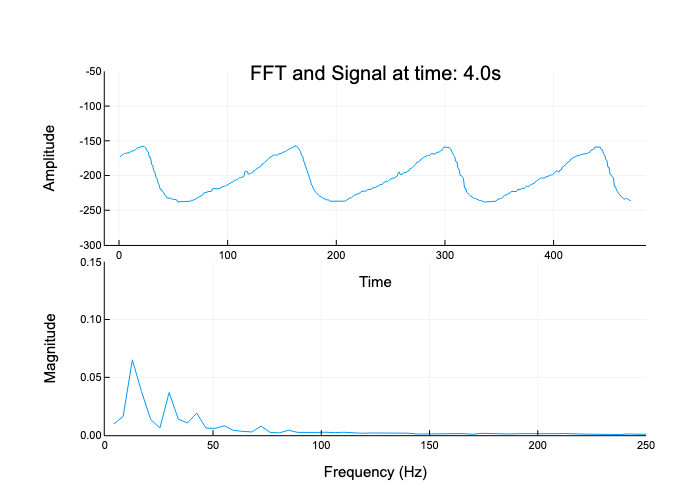

In [12]:
using Plots

# Assuming `input` is defined and contains the input signal for your system

# Set up the animation
anim = @animate for (index, i) in enumerate(signals2[1:end-1])
    fft_signal = abs.(fft(i))
    fft_signal = fft_signal / maximum(fft_signal)
    n = length(i)
    fs = 2000  # Example sampling rate, adjust according to your signal
    f = (0:n-1) * (fs / n)  # Frequency axis for FFT

    # Plot for the original signal
    p1 = plot(1:n, i, 
              title="FFT and Signal at time: $(round(times2[index]))s",
              xlabel="Time",
              ylabel="Amplitude")
	
			  

    # Plot for the Fourier Transform of the current signal
    p2 = plot(f[2:Int(floor(n/2))], fft_signal[2:Int(floor(n/2))],  
              xlabel="Frequency (Hz)", 
              ylabel="Magnitude")

    # Set plot limits for the FFT plot
    xlims!(p2, 0, fs/8)
    ylims!(p2, 0, 0.15)  # Assuming normalized FFT, adjust ylims as needed
    ylims!(p1, -300, -50)
    # Combine the two plots into a single frame for the animation
    plot(p1, p2, layout=(2, 1), size=(600, 800),legend=false)
end

# Save the animation as a gif
gif(anim, "fourier_transforms.gif", fps = 15)  # Adjust fps (frames per second) as needed

In [13]:
# Given values
fs = 2000  # Sampling rate
n = length(signals2[1])  # Number of samples in the signal

# Calculate frequency resolution
frequency_resolution = fs / n

# Find the index for 60 Hz
index_for_60Hz = round(Int, 80 / frequency_resolution)

println("The index for 60 Hz is: ", index_for_60Hz)

The index for 60 Hz is: 19


In [14]:
A_45=[]
for i in signals2
    push!(A_45,abs.(fft(i)[3]))
end

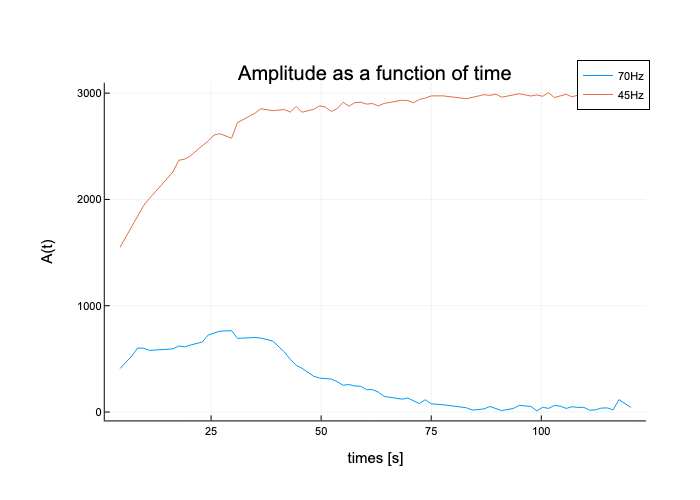

In [15]:
A_70=[]
for i in signals2
    push!(A_70,abs.(fft(i)[21]))
end
plot(times2,A_70,xlabel="times [s]",ylabel="A(t)",label="70Hz")
plot!(times2,A_45,xlabel="times [s]",ylabel="A(t)",label="45Hz",title="Amplitude as a function of time")